In [319]:
import pandas as pd
import math
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

pd.options.display.max_rows = 999
pd.options.display.max_columns = 200

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import glob
from tqdm.notebook import tqdm
import itertools
import time

import warnings
warnings.filterwarnings("ignore")



# initialization

## global variable

In [320]:
NUM_YEAR = 20
NUM_YEAR_FORECAST = 14
TIME_STEP_PER_YEAR = 4

STEP_RANGE = NUM_YEAR * TIME_STEP_PER_YEAR
STEP_RANGE_FORECAST = NUM_YEAR_FORECAST * TIME_STEP_PER_YEAR


## demand

### EV forecast

In [321]:
steps_ev_demand = pd.read_excel('data/结果：全球EV对锂钴镍的需求预测.xlsx', skiprows=1, sheet_name=0)
steps_ev_demand = steps_ev_demand[['Year', 'Li demand', 'Co demand', 'Ni demand', 'Li demand.1',
                       'Co demand.1', 'Ni demand.1', 'EOL Li', 'EOL Co', 'EOL Ni', 'EOL Li.1',
                       'EOL Co.1', 'EOL Ni.1']]
steps_ev_demand.columns = ['year', 'STEPS_NCX_Li_demand', 'STEPS_NCX_Co_demand',
                    'STEPS_NCX_Ni_demand', 'STEPS_LFP_Li_demand',
                    'STEPS_LFP_Co_demand', 'STEPS_LFP_Ni_demand', 'STEPS_NCX_EOL_Li',
                    'STEPS_NCX_EOL_Co', 'STEPS_NCX_EOL_Ni', 'STEPS_LFP_EOL_Li',
                    'STEPS_LFP_EOL_Co', 'STEPS_LFP_EOL_Ni']
steps_ev_demand.head()


,year,STEPS_NCX_Li_demand,STEPS_NCX_Co_demand,STEPS_NCX_Ni_demand,STEPS_LFP_Li_demand,STEPS_LFP_Co_demand,STEPS_LFP_Ni_demand,STEPS_NCX_EOL_Li,STEPS_NCX_EOL_Co,STEPS_NCX_EOL_Ni,STEPS_LFP_EOL_Li,STEPS_LFP_EOL_Co,STEPS_LFP_EOL_Ni
0,2010,0.143719,0.168458,0.341628,0.143719,0.168458,0.341628,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,2011,0.285940,0.323876,0.690666,0.285940,0.323876,0.690666,4.677089e-07,5.482162e-07,0.000001,4.677089e-07,5.482162e-07,0.000001
2,2012,0.526513,0.588093,1.302426,0.526513,0.588093,1.302426,2.698768e-05,3.159638e-05,0.000064,2.698768e-05,3.159638e-05,0.000064
3,2013,0.913241,1.015481,2.364588,0.910166,0.990114,2.273879,3.270288e-04,3.811804e-04,0.000780,3.270288e-04,3.811804e-04,0.000780
4,2014,1.545928,1.660004,3.920547,1.545928,1.660004,3.920547,2.085780e-03,2.417892e-03,0.004989,2.085770e-03,2.417809e-03,0.004988


In [322]:
sds_ev_demand = pd.read_excel('data/结果：全球EV对锂钴镍的需求预测.xlsx', skiprows=1, sheet_name=1)
sds_ev_demand = sds_ev_demand[['Year', 'Li demand', 'Co demand', 'Ni demand', 'Li demand.1',
                       'Co demand.1', 'Ni demand.1', 'EOL Li', 'EOL Co', 'EOL Ni', 'EOL Li.1',
                       'EOL Co.1', 'EOL Ni.1']]
sds_ev_demand.columns = ['year', 'SDS_NCX_Li_demand', 'SDS_NCX_Co_demand',
                     'SDS_NCX_Ni_demand', 'SDS_LFP_Li_demand', 'SDS_LFP_Co_demand',
                     'SDS_LFP_Ni_demand', 'SDS_NCX_EOL_Li', 'SDS_NCX_EOL_Co',
                     'SDS_NCX_EOL_Ni', 'SDS_LFP_EOL_Li', 'SDS_LFP_EOL_Co',
                     'SDS_LFP_EOL_Ni']
sds_ev_demand.head()


,year,SDS_NCX_Li_demand,SDS_NCX_Co_demand,SDS_NCX_Ni_demand,SDS_LFP_Li_demand,SDS_LFP_Co_demand,SDS_LFP_Ni_demand,SDS_NCX_EOL_Li,SDS_NCX_EOL_Co,SDS_NCX_EOL_Ni,SDS_LFP_EOL_Li,SDS_LFP_EOL_Co,SDS_LFP_EOL_Ni
0,2010,0.143719,0.168458,0.341628,0.143719,0.168458,0.341628,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,2011,0.285940,0.323876,0.690666,0.285940,0.323876,0.690666,4.677089e-07,5.482162e-07,0.000001,4.677089e-07,5.482162e-07,0.000001
2,2012,0.526513,0.588093,1.302426,0.526513,0.588093,1.302426,2.698768e-05,3.159638e-05,0.000064,2.698768e-05,3.159638e-05,0.000064
3,2013,0.913241,1.015481,2.364588,0.910166,0.990114,2.273879,3.270288e-04,3.811804e-04,0.000780,3.270288e-04,3.811804e-04,0.000780
4,2014,1.545928,1.660004,3.920547,1.545928,1.660004,3.920547,2.085780e-03,2.417892e-03,0.004989,2.085770e-03,2.417809e-03,0.004988


In [323]:
ev_demand = pd.merge(steps_ev_demand, sds_ev_demand, on='year')


### IEA forecast

In [324]:
demand_f_df = pd.read_csv('total-nickel-demand-by-sector-and-scenario-2020-2040.csv', skiprows=3)
del demand_f_df['Unnamed: 0']
demand_f_df = demand_f_df.iloc[[0, 3, 4]]
demand_f_df['year'] = [2020, 2030, 2040]
demand_f_df['Other sectors'] = demand_f_df['Low-carbon power generation'] + demand_f_df['Hydrogen'] + demand_f_df['Other sectors'] 
demand_f_df


,Low-carbon power generation,EVs and storage,Hydrogen,Other sectors,Share of clean energy technologies,year
0,115.39,80.87,0.00,2259.69,8.39,2020
3,633.57,1592.43,7.36,2981.56,48.83,2030
4,444.90,3352.21,15.38,2913.53,60.85,2040


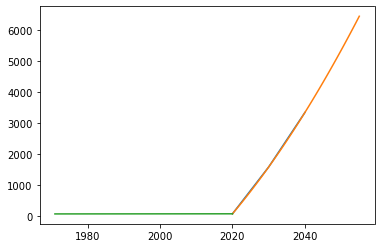

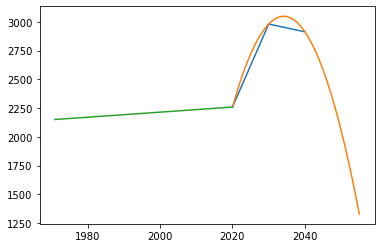

In [325]:
# demand projection

year = demand_f_df['year'].tolist()
ev_demand_base = demand_f_df['EVs and storage'].tolist()
other_demand_base = demand_f_df['Other sectors'].tolist()

year_projection = np.linspace(2020, 2055, 35 * 1 + 1)
year_projection2 = np.linspace(1971, 2020, 50 * 1)

def fit(x, a, b, c):
    return a*x**2+b*x + c
fitting_parameters, covariance = curve_fit(fit, year, ev_demand_base)
a, b, c = fitting_parameters
ev_demand_projection = fit(year_projection, a, b, c)
plt.plot(year, ev_demand_base)
plt.plot(year_projection, ev_demand_projection)

def fit(x, a):
    return a * x**2
fitting_parameters, covariance = curve_fit(fit, [year[0]], [ev_demand_base[0]])
a = fitting_parameters[0]
ev_demand_projection2 = fit(year_projection2, a)
plt.plot(year_projection2, ev_demand_projection2)
plt.show()


def fit(x, a, b, c):
    return a*x**2 + b*x + c
fitting_parameters, covariance = curve_fit(fit, year, other_demand_base)
a, b, c = fitting_parameters
other_demand_projection = fit(year_projection, a, b, c)
plt.plot(year, other_demand_base)
plt.plot(year_projection, other_demand_projection)

def fit(x, a):
    return a * x**2
fitting_parameters, covariance = curve_fit(fit, [year[0]], [other_demand_base[0]])
a = fitting_parameters
other_demand_projection2 = fit(year_projection2, a)
plt.plot(year_projection2, other_demand_projection2)
plt.show()


In [326]:
demand = pd.DataFrame([np.append(year_projection[1:], year_projection2),
                       np.append(ev_demand_projection[1:], ev_demand_projection2),
                       np.append(other_demand_projection[1:], other_demand_projection2)],
                      index=['year', 'ev_demand', 'other_demand']).T
demand = demand.sort_values(by='year').reset_index(drop=True)
demand['year'] = demand['year'].astype(int)
demand


,year,ev_demand,other_demand
0,1971,76.994190,2151.391128
1,1972,77.072337,2153.574727
2,1973,77.150523,2155.759434
3,1974,77.228749,2157.945248
4,1975,77.307015,2160.132170
5,1976,77.385320,2162.320199
6,1977,77.463665,2164.509336
7,1978,77.542050,2166.699581
8,1979,77.620474,2168.890933
9,1980,77.698938,2171.083393


In [328]:
# other_sector_eol

lifetimes = 50
total_years = 85
stock_matrix = np.zeros((total_years, total_years))
outflow_matrix =  np.zeros((total_years, total_years))

for k in range(total_years):
    stock_matrix[k, k:] = truncnorm.cdf(x=range(total_years-k), a=-lifetimes, b=np.inf, loc=lifetimes, scale=lifetimes*0.3) * \
                          np.array(demand.iloc[k]['other_demand'])
    if k!=total_years:
        outflow_matrix[k, k+1:] = np.array(demand.iloc[k]['other_demand']) * \
                                 (truncnorm.cdf(x=range(1, total_years-k), a=-lifetimes, b=np.inf, loc=lifetimes, scale=lifetimes*0.3) - \
                                  truncnorm.cdf(x=range(total_years-k-1), a=-lifetimes, b=np.inf, loc=lifetimes, scale=lifetimes*0.3))

demand['other_sector_eol'] = outflow_matrix.sum(axis=0)


In [329]:
demand = pd.merge(ev_demand, demand, on='year')
demand.head()


,year,STEPS_NCX_Li_demand,STEPS_NCX_Co_demand,STEPS_NCX_Ni_demand,STEPS_LFP_Li_demand,STEPS_LFP_Co_demand,STEPS_LFP_Ni_demand,STEPS_NCX_EOL_Li,STEPS_NCX_EOL_Co,STEPS_NCX_EOL_Ni,STEPS_LFP_EOL_Li,STEPS_LFP_EOL_Co,STEPS_LFP_EOL_Ni,SDS_NCX_Li_demand,SDS_NCX_Co_demand,SDS_NCX_Ni_demand,SDS_LFP_Li_demand,SDS_LFP_Co_demand,SDS_LFP_Ni_demand,SDS_NCX_EOL_Li,SDS_NCX_EOL_Co,SDS_NCX_EOL_Ni,SDS_LFP_EOL_Li,SDS_LFP_EOL_Co,SDS_LFP_EOL_Ni,ev_demand,other_demand,other_sector_eol
0,2010,0.143719,0.168458,0.341628,0.143719,0.168458,0.341628,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.143719,0.168458,0.341628,0.143719,0.168458,0.341628,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,80.071289,2237.372211,501.652301
1,2011,0.285940,0.323876,0.690666,0.285940,0.323876,0.690666,4.677089e-07,5.482162e-07,0.000001,4.677089e-07,5.482162e-07,0.000001,0.285940,0.323876,0.690666,0.285940,0.323876,0.690666,4.677089e-07,5.482162e-07,0.000001,4.677089e-07,5.482162e-07,0.000001,80.150982,2239.599006,546.940477
2,2012,0.526513,0.588093,1.302426,0.526513,0.588093,1.302426,2.698768e-05,3.159638e-05,0.000064,2.698768e-05,3.159638e-05,0.000064,0.526513,0.588093,1.302426,0.526513,0.588093,1.302426,2.698768e-05,3.159638e-05,0.000064,2.698768e-05,3.159638e-05,0.000064,80.230714,2241.826908,594.308754
3,2013,0.913241,1.015481,2.364588,0.910166,0.990114,2.273879,3.270288e-04,3.811804e-04,0.000780,3.270288e-04,3.811804e-04,0.000780,0.913241,1.015481,2.364588,0.910166,0.990114,2.273879,3.270288e-04,3.811804e-04,0.000780,3.270288e-04,3.811804e-04,0.000780,80.310486,2244.055918,643.634682
4,2014,1.545928,1.660004,3.920547,1.545928,1.660004,3.920547,2.085780e-03,2.417892e-03,0.004989,2.085770e-03,2.417809e-03,0.004988,1.545928,1.660004,3.920547,1.545928,1.660004,3.920547,2.085780e-03,2.417892e-03,0.004989,2.085770e-03,2.417809e-03,0.004988,80.390298,2246.286035,694.773329


In [330]:
# collection_rate

year_projection = np.linspace(2019, 2055, 37)

def fit(x, a, b):
    return a*x**2+b*x
fitting_parameters, covariance = curve_fit(fit, [2019, 2055], [0.45, 0.99])
a, b = fitting_parameters
collection_rate_projection = fit(year_projection, a, b)
demand.loc[9:40, 'collection_rate_projection'] = collection_rate_projection

plt.plot(year_projection, collection_rate_projection)


ValueError: could not broadcast input array from shape (37,) into shape (32,)

In [ ]:
demand['STEPS_LFP_recycled_Ni'] = (demand['other_sector_eol'] + demand['STEPS_LFP_EOL_Ni']) * \
                                   demand['collection_rate_projection'] * \
                                   0.95

demand['STEPS_LFP_overall_Ni_demand'] = demand['STEPS_LFP_Ni_demand'] + demand['other_demand']
demand['STEPS_LFP_primary_Ni_demand'] = demand['STEPS_LFP_overall_Ni_demand'] - demand['STEPS_LFP_recycled_Ni']


In [ ]:
hist_demand = demand[demand['year']>=2019]['STEPS_LFP_primary_Ni_demand'].tolist()
hist_year = (demand[demand['year']>=2019]['year']+0.5).tolist()


In [ ]:
f = interp1d(hist_year, hist_demand, kind='cubic')
hist_year_interpolated = np.linspace(hist_year[0], hist_year[-1], 31 * TIME_STEP_PER_YEAR + 1)
hist_demand_interpolated = f(hist_year_interpolated)
hist_year_interpolated
hist_demand_interpolated


In [ ]:
plt.plot(hist_year, hist_demand)
plt.show()
plt.plot(hist_year_interpolated, hist_demand_interpolated)
plt.show()


In [ ]:
preset_demand = [i / TIME_STEP_PER_YEAR for i in hist_demand_interpolated[2:]]
len(preset_demand)
preset_demand


In [ ]:
len(preset_demand)

In [315]:
demand_f = np.array([preset_demand[i:i+STEP_RANGE_FORECAST] for i in range(STEP_RANGE)])
demand_f.shape


(120,)

In [317]:
STEP_RANGE

120

### prediction

In [15]:
# growth_f = np.empty(shape=(NUM_YEAR*TIME_STEP_PER_YEAR))
# growth_f[:] = np.NaN

# demand_f = trend_f = np.empty(shape=(NUM_YEAR*TIME_STEP_PER_YEAR, NUM_YEAR_FORECAST*TIME_STEP_PER_YEAR))
# demand_f[:] = trend_f[:] = np.NaN

# alpha_dtdf = (1 - np.exp(np.log10(0.5) / (3 * TIME_STEP_PER_YEAR)))
# alpha_dgdf = (1 - np.exp(np.log10(0.5) / (3 * TIME_STEP_PER_YEAR)))
# r_dfdt = np.log10(2) / (3/4)
 

# growth_f[0] = growth_rate
# trend_f[0][0] = hist_demand_interpolated[-1]
# for tf in range(STEP_RANGE_FORECAST):
#     trend_f[0, tf] = trend_f[0, 0] * (1 + growth_f[0])**(tf-0)


## supply

In [16]:
df = pd.read_excel('nickel_mine_final.xlsx')
df = df.applymap(lambda x: str(x).replace('*', '').replace('nan', '')).apply(pd.to_numeric, errors='ignore')


### lead time analysis

,sumsquare_error,aic,bic,kl_div
chi2,1.386311,753.725861,-82.032935,inf


array([ 2,  2,  4,  5, 27, 18,  4, 17,  2,  2, 11, 10,  2,  3,  4,  3, 34,
        5, 12,  7, 16,  2,  6, 13,  3, 13,  4, 15,  4,  2,  5,  4,  3,  8,
        9, 19,  8, 11,  4,  3,  4,  2,  4, 19,  3, 25,  2,  3,  2,  8,  2,
       17,  3, 11, 10,  4,  8, 14, 19,  3, 23, 14,  5,  2, 15,  8,  7,  4,
       20,  6, 19,  4, 13, 18, 19, 27,  8,  9, 10,  2,  7,  6,  5,  5, 11,
        4,  3,  5,  6,  5,  3, 18,  2,  3,  4,  2,  2,  8,  4,  2])

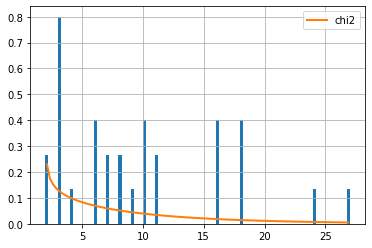

In [17]:
from fitter import get_common_distributions, Fitter, get_distributions
from scipy.stats import chi2
from scipy.stats import uniform

dev_lead_time = [2,3,2,4,3,3,3,3,8,6,8,3,10,7,6,10,10,6,7,11,16,11,16,16,9,18,18,18,24,27]

# f1 = Fitter(dev_lead_time,
#             distributions=get_common_distributions())
# f1.fit()
# f1.summary()

f1 = Fitter(dev_lead_time,
            distributions=['chi2'])
f1.fit()
f1.summary()

chi2.rvs(size=100, **f1.get_best()['chi2']).astype(int)


,sumsquare_error,aic,bic,kl_div
uniform,15.226337,443.444915,-13.542727,inf


array([4, 6, 8, 0, 2, 2, 0, 6, 2, 4, 2, 4, 0, 2, 3, 7, 7, 0, 8, 4, 6, 0,
       4, 6, 0, 1, 5, 7, 8, 5, 3, 6, 8, 1, 4, 8, 6, 2, 5, 2, 4, 1, 4, 7,
       1, 7, 8, 2, 0, 6, 8, 5, 3, 3, 8, 0, 5, 8, 0, 7, 5, 7, 8, 7, 4, 3,
       1, 4, 6, 6, 5, 1, 4, 8, 4, 1, 1, 8, 2, 3, 7, 5, 6, 2, 1, 8, 8, 7,
       0, 3, 7, 1, 5, 4, 5, 6, 5, 5, 4, 0])

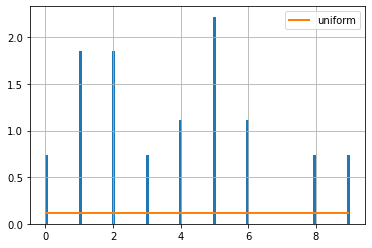

In [18]:
# 0 9 4
dev_lead_time = [2,1,3,2,5,5,5,6,2,4,3,8,1,4,6,2,4,9,8,5,1,6,1,2,9,1,5,5,0,0]


# f2 = Fitter(dev_lead_time,
#             distributions=get_common_distributions())
# f2.fit()
# f2.summary()

f2 = Fitter(dev_lead_time,
            distributions=['uniform'])
f2.fit()
f2.summary()

uniform.rvs(size=100, **f2.get_best()['uniform']).astype(int)


### current stage

In [19]:
stage_dic = {'Grassroots':'Early-stage exploration',
'Exploration':'Early-stage exploration',
'Target Outline':'Early-stage exploration',

'Advanced Exploration':'Late-stage exploration',
'Prefeas/Scoping':'Late-stage exploration',
 
'Feasibility Started':'Feasibility-stage',
'Feasibility':'Feasibility-stage',
 
'Feasibility Complete':'Development-stage',
'Reserves Development':'Development-stage',

'Satellite':'Construction-stage',
'Construction Planned':'Construction-stage',
'Construction Started':'Construction-stage',
 
'Commissioning':'Construction-stage',
'Preproduction':'Construction-stage',

'Operating':'Operating-stage',
 
'Limited Production':'Operating-stage',
'Expansion':'Operating-stage',
'Closed':'Closed-stage'}

df['current_stage'] = df['dev_stage'].map(stage_dic)


In [20]:
df = df[df['mine_type1']!='Ocean']

df = df[df['resource_metal (mt)'].notnull()]

df.loc[(df['production_PROD_Ni_tpa'].isnull())&(df['current_stage'].isin(['Operating-stage'])), 'current_stage']='Development-stage' 
df.loc[(df['reserve_metal (mt)'].isnull())&(df['current_stage'].isin(['Development-stage', 'Operating-stage'])), 'current_stage']='Feasibility-stage'

df.loc[(df['production_PROD_Ni_tpa'].notnull())&(df['current_stage'].isin(['Early-stage exploration', 'Late-stage exploration', 'Feasibility-stage', 'Development-stage'])), 'current_stage']='Operating-stage' 
df.loc[(df['reserve_metal (mt)'].notnull())&(df['current_stage'].isin(['Early-stage exploration', 'Late-stage exploration', 'Feasibility-stage'])), 'current_stage']='Development-stage'

df = df[df['current_stage']!='Early-stage exploration']
# df = df[df['dev_stage']!='Closed-stage']
# df = df[df['actv_status']!='Inactive']


### regional risk and probability of shutdown

In [21]:
df['country/region_ter_risk'] = df['country/region_ter_risk'].map({'Medium':2, 'High':3, 'Low':1, 'Insignificant':0}).fillna(2)
df['country/region_sec_risk'] = df['country/region_sec_risk'].map({'Medium':2, 'High':3, 'Low':1, 'Insignificant':0}).fillna(2)
df['country/region_pol_risk'] = df['country/region_pol_risk'].map({'Medium':2, 'High':3, 'Low':1, 'Insignificant':0}).fillna(2)
df['country/region_op_risk'] = df['country/region_op_risk'].map({'Medium':2, 'High':3, 'Low':1, }).fillna(2)
df['country/region_overall_risk'] = df['country/region_ter_risk'] + df['country/region_sec_risk'] + \
                                     df['country/region_pol_risk'] + df['country/region_op_risk']


In [22]:
df['prob_shutdown'] = df['country/region_overall_risk'] / 10
# df['prob_shutdown'] = np.sqrt(df['country/region_overall_risk'] / 10)


### other basic features

In [23]:
df['partial_production'] = df['production_PROD_Ni_tpa'] # currently 70% of production capacity 
df['expand_left_time'] = np.nan
df['if_adjust_production'] = np.nan


### init function

In [24]:
supply_simulation_resList = []


In [25]:
def init_supply_data(df, overall_left_year_limit=20):
    df2 = df.copy()

    exp_stage_index = df2['current_stage']=='Late-stage exploration'
    df2.loc[exp_stage_index, 'late_exp_stage_lead_time'] = np.round(np.random.uniform(0, 3, size=sum(exp_stage_index)) * TIME_STEP_PER_YEAR, 0)
    df2.loc[exp_stage_index, 'late_exp_stage_left_time'] = np.round(df2.loc[exp_stage_index, 'late_exp_stage_lead_time'] * np.random.rand(sum(exp_stage_index)), 0)

    fea_stage_index = df2['current_stage'].isin(['Late-stage exploration', 'Feasibility-stage'])
    df2.loc[fea_stage_index, 'fea_stage_lead_time'] = np.round(chi2.rvs(size=sum(fea_stage_index), **f1.get_best()['chi2']) * TIME_STEP_PER_YEAR, 0)
    df2.loc[fea_stage_index, 'fea_stage_left_time'] = np.round(df2.loc[fea_stage_index, 'fea_stage_lead_time'] * np.random.rand(sum(fea_stage_index)), 0)

    dev_stage_index = df2['current_stage'].isin(['Late-stage exploration', 'Feasibility-stage', 'Development-stage', 'Construction-stage'])
    df2.loc[dev_stage_index, 'dev_stage_lead_time'] = np.round(uniform.rvs(size=sum(dev_stage_index), **f2.get_best()['uniform']) * TIME_STEP_PER_YEAR, 0)
    df2.loc[dev_stage_index, 'dev_stage_left_time'] = np.round(df2.loc[dev_stage_index, 'dev_stage_lead_time'] * np.random.rand(sum(dev_stage_index)), 0)

    df2['overall_left_time'] = df2['late_exp_stage_left_time'].fillna(0) + df2['fea_stage_left_time'].fillna(0) + df2['dev_stage_left_time'].fillna(0)
    df2['overall_lead_time'] = df2['late_exp_stage_lead_time'].fillna(0) + df2['fea_stage_lead_time'].fillna(0) + df2['dev_stage_lead_time'].fillna(0)

    df2['overall_left_time'] = df2['overall_left_time'].map(lambda x: min(x, overall_left_year_limit * TIME_STEP_PER_YEAR))
    df2['dev_stage_left_time'] = np.round(df2['dev_stage_left_time'] / (df2['dev_stage_left_time']+ df2['fea_stage_left_time'].fillna(0) + df2['late_exp_stage_left_time'].fillna(0)) * df2['overall_left_time'].fillna(0), 0)
    df2['fea_stage_left_time'] = np.round(df2['fea_stage_left_time'] / (df2['fea_stage_left_time'] + df2['late_exp_stage_left_time'].fillna(0)) * (df2['overall_left_time'].fillna(0) - df2['dev_stage_left_time'].fillna(0)), 0)
    df2['late_exp_stage_left_time'] = df2['overall_left_time'] - df2['dev_stage_left_time'] - df2['fea_stage_left_time']

    df2['overall_left_time'].hist()
    df2['fea_stage_left_time'].hist()
    df2['dev_stage_left_time'].hist()
    
    supply_simulation = []
    supply_f = np.empty(shape=(NUM_YEAR * TIME_STEP_PER_YEAR, NUM_YEAR_FORECAST * TIME_STEP_PER_YEAR))
    supply_f[:] = np.NaN
    
    df2['num_halt_developing'] = 0
    df2['num_shutdown'] = 0
    df2['num_restore'] = 0
    df2['num_expansion'] = 0
    df2['num_adjust_production'] = 0
    
    df2['last_time_halt_developing'] = -9999
    df2['last_time_shutdown'] = -9999

    return df2, supply_f, supply_simulation


## price

<AxesSubplot:>

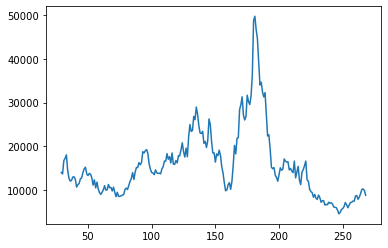

In [26]:
price_df = pd.read_excel('data/SPGlobal_PriceChart-Nickel(Chart)_12-May-2022.xls', sheet_name=1, skiprows=8)
price_df['Year-Month'] = price_df['Date'].map(lambda x: str(x)[:7])
price_df['Month'] = price_df['Date'].map(lambda x: str(x)[5:7])
price_df = price_df.sort_values(by='Year-Month')
price_df = price_df[price_df['Year-Month']<'2020-01']
# price_df = price_df[price_df['Month'].isin(['01', '04', '07', '10'])]
price_df['LME-Nickel Cash ($/tonne)'].plot()
hist_price = price_df['LME-Nickel Cash ($/tonne)'].tolist()


### init_function

In [27]:
def init_price_data(df):
    price_ma = np.empty(shape=(NUM_YEAR*TIME_STEP_PER_YEAR))
    price_ma[:] = np.NaN

    price_range = np.empty(shape=(NUM_YEAR * TIME_STEP_PER_YEAR, NUM_YEAR_FORECAST * TIME_STEP_PER_YEAR))
    price_f = np.empty(shape=(NUM_YEAR * TIME_STEP_PER_YEAR, NUM_YEAR_FORECAST * TIME_STEP_PER_YEAR))
    price_range[:] = np.NaN
    price_f[:] = np.NaN

#     price_dsm = np.empty(shape=(NUM_YEAR * TIME_STEP_PER_YEAR, NUM_YEAR_FORECAST * TIME_STEP_PER_YEAR))
#     price_dsm[:] = np.NaN

    price_simulation = []

    return price_ma, price_range, price_f, price_simulation


In [28]:
price_simulation_resList = []


# run simulation

## variable

In [108]:
# for decision-making and simulation
prob_produce = 0.2 # probability of developing deposits reaching operating stage 
mine_life_avg = 20 # average of mines' life for calculating probability of shutdown at each time step

expansion_cutoff = 1.8 # threshold for expansion
full_capacity_cutoff = 1.4 # threshold for producing at full capacity
partial_production_ratio = 0.7 # ratio of partial production to production capacity

r_cc = 0.05 # discount rate used for future cash cost
t_LR = 4 # interval for price forecast time range for halting/restoring developing deposits (long run | in years)
t_SR = 4 # interval for price forecast time range for shutting down operating deposits (short run | in years)
t_EXP = 4 # interval for price forecast time range for expanding operating deposits (short run | in years)
t_SR *= TIME_STEP_PER_YEAR # intervals
t_LR *= TIME_STEP_PER_YEAR # intervals
t_EXP *= TIME_STEP_PER_YEAR # intervals


In [109]:
# for price forecast
base_response = 10 # smaller the smalaler ds effect
half_life_price_infl = 2 # larger the smaller ds effect
half_life_price_ma = 1
# half_life_price_conv = 10 # larger the smaller ma/p gap effect
half_life_price_ma *= TIME_STEP_PER_YEAR
half_life_price_infl *= TIME_STEP_PER_YEAR
# half_life_price_conv *= TIME_STEP_PER_YEAR

a_ppf = 1 - np.exp(np.log(0.5) / (half_life_price_ma))
# a_ppf = 1 - np.exp(np.log(0.5) / (half_life_price_ma * TIME_STEP_PER_YEAR))
r_pfr = -np.log(2) / half_life_price_infl
# r_pfpmaf = -np.log(2) / half_life_price_conv


## main function

In [31]:
# long's equation
def func(x,a,b):
      return a*np.power(x, b)


In [32]:
def supply_simulation_one_step(df, t, tf, record=False):
    df_t = df.copy()

    # have stepped into operating stage
    df_t.loc[df_t['overall_left_time']<=0, 'current_stage'] = 'Operating-stage'
    df_t.loc[df_t['overall_left_time']<=0, 'dev_stage_left_time'] = np.nan
    op_stage_index = df_t['current_stage'].isin(['Operating-stage'])
    non_op_stage_index = df_t['current_stage'].isin(['Feasibility-stage', 'Late-stage exploration', 'Construction-stage', 'Development-stage']) 

    # step into new stage now
    df_t.loc[non_op_stage_index, 'overall_left_time'] -= 1

    exp_stage_index = (df_t['current_stage']=='Late-stage exploration')
    df_t.loc[exp_stage_index, 'late_exp_stage_left_time'] -=1
    exp_stage_finished_index = (-df_t['late_exp_stage_left_time']>0) # enter new stage
    df_t.loc[exp_stage_finished_index, 'late_exp_stage_left_time'] = np.nan
    df_t.loc[exp_stage_finished_index, 'current_stage'] = 'Feasibility-stage'

    fea_stage_index = (df_t['current_stage'].isin(['Feasibility-stage']))
    df_t.loc[fea_stage_index, 'fea_stage_left_time'] -=1
    fea_finished_index = (-df_t['fea_stage_left_time']>0) # reserve delcaration and enter new stage
    df_t.loc[fea_finished_index, 'fea_stage_left_time'] = np.nan
    df_t.loc[fea_finished_index, 'current_stage'] = 'Development-stage'

    dev_stage_index = (df_t['current_stage'].isin(['Development-stage', 'Construction-stage']))
    df_t.loc[dev_stage_index, 'dev_stage_left_time'] -=1
    dev_finished_index = (-df_t['dev_stage_left_time']>0) # enter new stage
    df_t.loc[dev_finished_index, 'dev_stage_left_time'] = np.nan
    df_t.loc[dev_finished_index, 'current_stage'] = 'Operating-stage'

    op_stage_index = (df_t['current_stage'].isin(['Operating-stage']))
    non_op_stage_index = df_t['current_stage'].isin(['Feasibility-stage', 'Late-stage exploration', 'Construction-stage', 'Development-stage'])

    # probability of producing
    df_t['dev_complete_ratio'] = (1 - df_t['overall_left_time'] / df_t['overall_lead_time']).fillna(1)
    df_t.loc[:, 'prob_produce'] = np.nan
    df_t.loc[op_stage_index, 'prob_produce'] = 1
    df_t.loc[non_op_stage_index, 'prob_produce'] = df_t.loc[non_op_stage_index].apply(
                                                   lambda x: prob_produce + (1 - prob_produce) * x['dev_complete_ratio'] if 
                                                   tf / x['overall_lead_time'] + x['dev_complete_ratio'] >= 1 else 0, axis=1)

    # reserve declaration
    resv_delcare_index = op_stage_index & (df_t['reserve_metal (mt)'].isnull())
    modification_rate = np.random.normal(loc=0.4, scale=0.1, size=sum(resv_delcare_index))
    df_t.loc[resv_delcare_index, 'reserve_metal (mt)'] = df_t.loc[resv_delcare_index, 'resource_metal (mt)'] * modification_rate
    
    # production capacity declaration
    a = 0.01692391768667905; b = 0.7078073223232975 # Laterite
    df_t['production_capacity_L'] = df_t['reserve_metal (mt)'].map(lambda x: func(x,a,b)) * 350
    a = 7.500699276531266e-06; b = 1.1996374863757813 # Magmatic Sulphide
    df_t['production_capacity_S'] = df_t['reserve_metal (mt)'].map(lambda x: func(x,a,b)) * 350
    sulphide_index = op_stage_index * (df_t['deposit_type']=='Magmatic Sulphide') & (df_t['production_capacity'].isnull())
    df_t.loc[sulphide_index, 'production_capacity'] = df_t.loc[sulphide_index, 'production_capacity_S']
    laterite_index = op_stage_index * (df_t['deposit_type']=='Laterite') & (df_t['production_capacity'].isnull())
    df_t.loc[laterite_index, 'production_capacity'] = df_t.loc[laterite_index, 'production_capacity_L']
    other_deposit_index = op_stage_index * (-df_t['deposit_type'].isin(['Magmatic Sulphide', 'Laterite'])) & (df_t['production_capacity'].isnull())
    df_t.loc[other_deposit_index, 'production_capacity'] = (df_t.loc[other_deposit_index, 'production_capacity_S'] + df_t.loc[other_deposit_index, 'production_capacity_L']) / 2
    df_t.loc[df_t['production_capacity']<100, 'current_stage'] = 'Closed-stage' # too low
    df_t.loc[df_t['production_capacity']<100, 'actv_status'] = 'Inactive' # too low

    # production declaration
    production_declare_index = op_stage_index & (df_t['production_PROD_Ni_tpa'].isnull())
    df_t.loc[production_declare_index, 'partial_production'] = df_t.loc[production_declare_index, 'production_capacity'] * partial_production_ratio
    df_t.loc[production_declare_index, 'production_PROD_Ni_tpa'] = df_t.loc[production_declare_index, 'partial_production']

    # expansion
    expand_index = op_stage_index & (df_t['expand_left_time'].notnull())
    df_t.loc[expand_index, 'production_PROD_Ni_tpa'] = df_t.loc[expand_index].apply(
        lambda x: x['production_PROD_Ni_tpa'] * 1.333 if x['expand_left_time']==12 else
        x['production_PROD_Ni_tpa'] * 1.25 if x['expand_left_time']==8 else
        x['production_PROD_Ni_tpa'] * 1.20 if x['expand_left_time']==4 else x['production_PROD_Ni_tpa'], axis=1)
    df_t.loc[expand_index, 'production_ROM_Ni_tpa'] = df_t.loc[expand_index].apply(
        lambda x: x['production_ROM_Ni_tpa'] * 1.333 if x['expand_left_time']==12 else
        x['production_ROM_Ni_tpa'] * 1.25 if x['expand_left_time']==8 else
        x['production_ROM_Ni_tpa'] * 1.20 if x['expand_left_time']==4 else x['production_ROM_Ni_tpa'], axis=1)
    df_t.loc[expand_index, 'production_capacity'] = df_t.loc[expand_index].apply(
        lambda x: x['production_capacity'] * 1.333 if x['expand_left_time']==12 else
        x['production_capacity'] * 1.25 if x['expand_left_time']==8 else
        x['production_capacity'] * 1.20 if x['expand_left_time']==4 else x['production_capacity'], axis=1)
    df_t.loc[expand_index, 'expand_left_time'] -= 1
    expand_finished_index = (df_t['expand_left_time'] <= 0)
    df_t.loc[expand_finished_index, 'expand_left_time'] = np.nan

    # capacity utilization
    increase_utilization_index  = op_stage_index & (df_t['if_adjust_production']==1)
    df_t.loc[increase_utilization_index, 'production_PROD_Ni_tpa'] = df_t.loc[increase_utilization_index, 'production_capacity']
    decrease_utilization_index = op_stage_index & (df_t['if_adjust_production']==-1)
    df_t.loc[decrease_utilization_index, 'production_PROD_Ni_tpa'] = df_t.loc[decrease_utilization_index, 'partial_production']
    
    # production
    df_t.loc[op_stage_index, 'production_PROD_Ni_tpa'] = df_t.loc[op_stage_index].apply(lambda x: min(x['production_PROD_Ni_tpa'], x['production_capacity']), axis=1) # can't exceed production capacity
    df_t.loc[op_stage_index, 'production_PROD_Ni_tpa'] = df_t.loc[op_stage_index].apply(lambda x: min(x['production_PROD_Ni_tpa'], x['recovery_Ni_perc'] * x['reserve_metal (mt)'] / 100), axis=1) # can't exceed remaining reserve
    df_t.loc[op_stage_index, 'production_ROM_Ni_tpa'] = df_t.loc[op_stage_index, 'production_PROD_Ni_tpa'] / df_t.loc[op_stage_index, 'recovery_Ni_perc'] * 100 # calculate raw ore containing nickel
    df_t.loc[op_stage_index & (df_t['production_PROD_Ni_tpa']<100), 'current_stage'] = 'Closed-stage' # too low
    df_t.loc[op_stage_index & (df_t['production_PROD_Ni_tpa']<100), 'actv_status'] = 'Inactive' # too low
    df_t.loc[op_stage_index, 'reserve_metal (mt)'] -= df_t.loc[op_stage_index, 'production_ROM_Ni_tpa'] / TIME_STEP_PER_YEAR # reserve decrease

    # if deplete
    resv_dep_index = op_stage_index & (df_t['reserve_metal (mt)']<=0)
    df_t.loc[resv_dep_index, 'reserve_metal (mt)'] = 0
    df_t.loc[resv_dep_index, 'production_PROD_Ni_tpa'] = df_t.loc[resv_dep_index, 'production_PROD_Ni_tpa'] = 0
    df_t.loc[resv_dep_index, 'current_stage'] = 'Closed-stage'
    df_t.loc[resv_dep_index, 'actv_status'] = 'Inactive'

    op_stage_index = df_t['current_stage'].isin(['Operating-stage'])
    supply = (df_t.loc[op_stage_index, 'production_PROD_Ni_tpa']  / TIME_STEP_PER_YEAR * df_t.loc[op_stage_index, 'prob_produce']).sum() / 10000
    
    records = [df_t.loc[op_stage_index, 'production_PROD_Ni_tpa'].sum() / TIME_STEP_PER_YEAR,
               df_t.loc[production_declare_index, 'production_PROD_Ni_tpa'].sum() / TIME_STEP_PER_YEAR,
               df_t.loc[resv_delcare_index, 'reserve_metal (mt)'].sum(),
               sum(op_stage_index)]
    
    if record:
        return df_t, supply, records
    else:
        return df_t, supply


In [33]:
def run_simulation(df, supply_f, supply_simulation, price_ma, price_range, price_f, price_simulation, silent=False):
    df_t = df.copy()
    df_t['action'] = ''
    records_lst = []

    for t in range(STEP_RANGE):
        # calculate moving adfverage price
        if not silent:
            print('+++'*50, '\n', '%d %d/%d'%(2020+t//TIME_STEP_PER_YEAR,
                                              t%TIME_STEP_PER_YEAR+1,
                                              TIME_STEP_PER_YEAR))
        price_ma[t] = sum(np.array([(1 - a_ppf)**i for i in range(len(hist_price), 0, -1)]) * np.array(hist_price))
        price_ma[t] /= sum(np.array([(1 - a_ppf)**i for i in range(len(hist_price), 0, -1)]))

        # ------------------------------------------------------------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------------------------------------------------------------
        # forecast
        for tf in range(STEP_RANGE_FORECAST):
            # ------------------------------------------------------------------------------------------------------------------------------------
            # demand forecast
#             trend_f[t, t] = (1 - alpha_dtdf) * trend_f[t-1, t] + alpha_dtdf * hist_demand_interpolated[-1] #Dt -> hist_demand_interpolated[-1]
#             growth_f[t] = (1 - alpha_dgdf) * np.log(1 + growth_f[t-1]) + alpha_dgdf * np.log(trend_f[t, t] / trend_f[t-1, t-1])
#             growth_f[t] = np.exp(growth_f[t]) - 1
#             trend_f[t, tf] = trend_f[t, t] * (1 + growth_f[t])**(tf - t)
#             demand_f[t, tf] = + np.exp(-r_dfdt * (tf - t)) * (hist_demand_interpolated[-1] - trend_f[t, tf]) #Dt -> hist_demand_interpolated[-1]

            # ------------------------------------------------------------------------------------------------------------------------------------
            # supply simulation and forecast
            if tf==0: # first step simulation without decision-making
                df_t, supply, records = supply_simulation_one_step(df_t, t, tf, record=True) # simulation without decision-making
                df_0 = df_t.copy()
                records_lst += [records]
            else:
                df_t, supply = supply_simulation_one_step(df_t, t, tf) # simulation without decision-making
                
            if supply / demand_f[t, tf] > 1.1:
                supply = demand_f[t, tf] * 1.1

            supply_f[t, tf] = supply

            # when forecasting, developing deposits have probability of being abandoned
            df_t['prob_abort_now'] = (1 - prob_produce) / df_t['overall_lead_time']
            prob_abort_index = (df_t['prob_abort_now'].notnull()) & (df_t['current_stage'].isin(['Feasibility-stage', 'Late-stage exploration', 'Construction-stage', 'Development-stage']))
            df_t.loc[prob_abort_index, 'if_abort_randomly'] = df_t.loc[prob_abort_index, 'prob_abort_now'].map(
                     lambda x: 0 if np.random.binomial(1, x, 1)[0]==0 else 1)
            df_t.loc[df_t['if_abort_randomly']==1, 'current_stage'] = 'Closed-stage'
            df_t.loc[df_t['if_abort_randomly']==1, ['overall_left_time', 'overall_lead_time']] = np.nan

            # when forecasting, operating deposits have probability of being shutdowned
            df_t['prob_shutdown_now'] = df_t['prob_shutdown'] / (mine_life_avg * TIME_STEP_PER_YEAR)
            prob_shutdown_index = (df_t['prob_shutdown_now'].notnull()) & (df_t['current_stage'].isin(['Operating-stage']))
            df_t.loc[prob_abort_index, 'if_shutdown_randomly'] = df_t.loc[prob_abort_index, 'prob_shutdown_now'].map(
                     lambda x: 0 if np.random.binomial(1, x, 1)[0]==0 else 1)
            df_t.loc[df_t['if_shutdown_randomly']==1, 'current_stage'] = 'Closed-stage'

            # ------------------------------------------------------------------------------------------------------------------------------------
            # price forecast
            price_range[t, tf] = base_response / TIME_STEP_PER_YEAR * np.exp(-r_pfr * tf / TIME_STEP_PER_YEAR)
#             if tf==0:
#                 price_dsm[t, tf] = np.log(price_ma[t]) + np.exp(-r_pfpmaf * 1/TIME_STEP_PER_YEAR) * (np.log(hist_price[-1]) - np.log(price_ma[t]))
#             else:
#                 price_dsm[t, tf] = np.log(price_ma[t]) + np.exp(-r_pfpmaf * 1/TIME_STEP_PER_YEAR) * (np.log(price_f[t, tf-1]) - np.log(price_ma[t]))
#             price_dsm[t, tf] = np.exp(price_dsm[t, tf])
#             price_f[t, tf] = np.exp(np.log(price_dsm[t, tf]) + price_range[t, tf] * np.log(demand_f[t, tf] / supply_f[t, tf]))        
            price_f[t, tf] = np.exp(np.log(price_ma[t]) + price_range[t, tf] * np.log(demand_f[t, tf] / supply_f[t, tf]))

            if tf%TIME_STEP_PER_YEAR==0:
                if not silent:
                    print('forecast time: +%d Year time_inf_range:%.2f pma:%.2f d:%.2f s:%.2f d/s:%.2f price:%.2f'%(
                          tf/TIME_STEP_PER_YEAR+1, price_range[t, tf], price_ma[t], demand_f[t, tf], supply_f[t, tf], demand_f[t, tf] / supply_f[t, tf], price_f[t, tf]))

        # ------------------------------------------------------------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------------------------------------------------------------
        # simulation
        # ------------------------------------------------------------------------------------------------------------------------------------
        # current step's (+1) simulation without decision-making
        df_t = df_0
#         every year developer has a chance to halt or restore (decision-making)
#         if t%TIME_STEP_PER_YEAR==0:

        df_t[['if_halt_developing', 'if_shutdown', 'if_restore']] = np.nan
        if not silent:
            print('decision-making:')

        # halt developing
        potential_halt_index = (t - df_t['last_time_halt_developing'] >= 10 * TIME_STEP_PER_YEAR) & \
            (df_t['overall_left_time'] >= 2.5 * TIME_STEP_PER_YEAR) & \
            (df_t['current_stage'].isin(['Feasibility-stage', 'Late-stage exploration', 'Construction-stage', 'Development-stage']))
        df_t.loc[potential_halt_index, 'overall_left_time2'] = df_t.loc[potential_halt_index, 'overall_left_time'].map(lambda x: min(x, 10*TIME_STEP_PER_YEAR))
        df_t.loc[potential_halt_index, 'if_halt_developing'] = df_t.loc[potential_halt_index].apply(
            lambda x: 1 if x['cash_cost (nickel USD/t)'] * (1+r_cc)**((t+int(x['overall_left_time2']))/TIME_STEP_PER_YEAR)\
            > np.mean(price_f[t, int(x['overall_left_time2']):int(x['overall_left_time2'] + t_LR)]) else 0, axis=1)
        df_t.loc[df_t['if_halt_developing']==1, 'last_time_halt_developing'] = t

        # shutdown
        potential_shutdown_index = (t - df_t['last_time_shutdown'] >= 10 * TIME_STEP_PER_YEAR) & \
            (df_t['current_stage']=='Operating-stage')
        df_t.loc[potential_shutdown_index, 'if_shutdown'] = df_t.loc[potential_shutdown_index].apply(
            lambda x: 1 if x['cash_cost (nickel USD/t)'] * (1+r_cc)**(t/TIME_STEP_PER_YEAR) > \
            np.mean(price_f[t, 0:t_SR]) else 0, axis=1)
        df_t.loc[df_t['if_shutdown']==1, 'last_time_shutdown'] = t

        if_abandon_index = (df_t['if_halt_developing']==1) | (df_t['if_shutdown']==1)
        df_t.loc[if_abandon_index, 'current_stage'] = 'halt'
        df_t.loc[if_abandon_index, 'dev_stage_left_time'] = df_t.loc[if_abandon_index, 'dev_stage_left_time'].fillna(0) + 2 * TIME_STEP_PER_YEAR
        df_t.loc[if_abandon_index, 'overall_left_time'] = df_t.loc[if_abandon_index, 'overall_left_time'].fillna(0) + 2 * TIME_STEP_PER_YEAR
        df_t.loc[if_abandon_index, 'overall_lead_time'] = df_t.loc[if_abandon_index, 'overall_lead_time'].fillna(0) + 2 * TIME_STEP_PER_YEAR

        # restore
        potential_restore_index = (df_t['current_stage']=='halt') & (-if_abandon_index)
        df_t.loc[potential_restore_index, 'overall_left_time2'] = df_t.loc[potential_restore_index, 'overall_left_time'].map(lambda x: min(x, 10*TIME_STEP_PER_YEAR))
        df_t.loc[potential_restore_index, 'if_restore'] = df_t.loc[potential_restore_index].apply(
            lambda x: 1 if x['cash_cost (nickel USD/t)'] * (1+r_cc)**((t+int(x['overall_left_time2'])) / TIME_STEP_PER_YEAR)\
            <= np.mean(price_f[t, int(x['overall_left_time2']):int(x['overall_left_time2'] + t_LR)]) else 0, axis=1)
        df_t.loc[df_t['if_restore']==1, 'current_stage'] = 'Development-stage'

        # capacity utilization
        potential_adjust_index = (df_t['current_stage']=='Operating-stage')
        df_t.loc[potential_adjust_index, 'if_adjust_production'] = df_t.loc[potential_adjust_index].apply(
            lambda x: 1 if x['cash_cost (nickel USD/t)'] * (1+r_cc)**(t / TIME_STEP_PER_YEAR)\
            <= 1 / full_capacity_cutoff * np.mean(price_f[t, 0:t_EXP]) else \
            -1 if x['cash_cost (nickel USD/t)'] * (1+r_cc)**(t / TIME_STEP_PER_YEAR)\
            <= np.mean(price_f[t, 0:t_EXP]) else 0, axis=1)

        # expansion
        potential_expand_index = (df_t['current_stage']=='Operating-stage') & (df_t['expand_left_time'].isnull())
        df_t.loc[potential_expand_index, 'expand_left_time'] = df_t.loc[potential_expand_index].apply(
            lambda x: 4 * TIME_STEP_PER_YEAR if x['cash_cost (nickel USD/t)'] * (1+r_cc)**(t / TIME_STEP_PER_YEAR)\
            <= 1 / expansion_cutoff * np.mean(price_f[t, 0:t_EXP]) else np.nan, axis=1)

        df_t.loc[abs(df_t['if_adjust_production'])==1, 'num_adjust_production'] += 1
        df_t.loc[df_t['if_halt_developing']==1, 'num_halt_developing'] += 1
        df_t.loc[df_t['if_shutdown']==1, 'num_shutdown'] += 1
        df_t.loc[df_t['if_restore']==1, 'num_restore'] += 1
        df_t.loc[df_t['expand_left_time']==4 * TIME_STEP_PER_YEAR, 'num_expansion'] += 1

        if not silent:
            print('halt developing:%d shutdown:%d restore:%d expanding:%d'%(df_t['if_halt_developing'].sum(), df_t['if_shutdown'].sum(), df_t['if_restore'].sum(), df_t['expand_left_time'].count()))

        
        # base on current step's (+1) simulation with decision-making as the inital status of next step's simulation        
        op_stage_index = df_t['current_stage']=='Operating-stage'
        supply = (df_t.loc[op_stage_index, 'production_PROD_Ni_tpa']).sum() / TIME_STEP_PER_YEAR / 10000

        supply_simulation += [supply]
        price_simulation += [price_f[t, 0]]
        
        df_t['action'] = df_t['action'] + '_' + df_t['current_stage']
        
        if not silent:
            print('supply:%.2f demand:%.2f price:%.2f'%(supply, demand_f[t, 0], price_f[t, 0]))

    #     if t==0:
    #         break
    return supply_simulation, price_simulation, df_t, records_lst


## debug

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2020 1/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:60.32 s:66.36 d/s:0.91 price:10405.87
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:61.98 s:68.18 d/s:0.91 price:10229.42
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:64.72 s:71.19 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:67.58 s:74.34 d/s:0.91 price:9848.25
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:70.57 s:77.62 d/s:0.91 price:9643.07
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:73.69 s:81.05 d/s:0.91 price:9427.90
forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:76.94 s:84.64 d/s:0.91 price:9202.61
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:80.34 s:88.38 d/s:0.91 price:8967.13
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:83.90 s:92.29 d/s

forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:71.33 s:67.45 d/s:1.06 price:15686.64
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:74.49 s:68.74 d/s:1.08 price:17210.96
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:77.78 s:75.94 d/s:1.02 price:14371.60
forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:81.22 s:63.80 d/s:1.27 price:32966.27
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:84.81 s:65.46 d/s:1.30 price:37807.70
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:88.56 s:63.73 d/s:1.39 price:55281.64
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:92.47 s:60.76 d/s:1.52 price:93665.55
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:96.56 s:62.22 d/s:1.55 price:118854.86
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:100.83 s:58.34 d/s:1.73 price:247717.46
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:105.29 s:53.77 d/s:1.96 price:626535.80
forecast time: +14 Year time_in

forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:85.73 s:77.65 d/s:1.10 price:19219.13
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:89.52 s:72.27 d/s:1.24 price:31505.44
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:93.48 s:68.61 d/s:1.36 price:50753.65
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:97.61 s:67.27 d/s:1.45 price:74978.87
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:101.92 s:60.77 d/s:1.68 price:175326.71
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:106.43 s:56.63 d/s:1.88 price:388406.73
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:111.14 s:53.64 d/s:2.07 price:866944.20
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:116.05 s:50.38 d/s:2.30 price:2246251.72
decision-making:
halt developing:0 shutdown:7 restore:0 expanding:50
supply:63.26 demand:66.13 price:13380.01
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:94.49 s:82.85 d/s:1.14 price:22526.79
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:98.67 s:81.85 d/s:1.21 price:29795.09
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:103.03 s:72.84 d/s:1.41 price:66564.33
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:107.59 s:66.13 d/s:1.63 price:150486.10
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:112.34 s:59.32 d/s:1.89 price:404489.58
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:117.31 s:51.73 d/s:2.27 price:1455464.59
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:122.50 s:45.91 d/s:2.67 price:5552139.22
decision-making:
halt developing:0 shutdown:6 restore:2 expanding:53
supply:82.96 demand:69.81 price:10405.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2024 1/4
forecast time: +1 Year time_inf_range:2.

forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:108.76 s:69.49 d/s:1.57 price:106715.09
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:113.57 s:61.57 d/s:1.84 price:282025.80
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:118.59 s:51.62 d/s:2.30 price:1138911.11
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:123.83 s:45.04 d/s:2.75 price:4400583.96
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:129.30 s:40.65 d/s:3.18 price:16389789.50
decision-making:
halt developing:0 shutdown:8 restore:6 expanding:51
supply:79.13 demand:73.69 price:10405.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2025 2/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:74.49 s:81.94 d/s:0.91 price:10405.87
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:77.78 s:85.56 d/s:0.91 price:10229.42
forecast time: +3 Year time_inf_range

forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:119.87 s:52.80 d/s:2.27 price:796588.35
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:125.17 s:45.69 d/s:2.74 price:2926699.64
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:130.71 s:40.28 d/s:3.25 price:11401951.61
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:136.49 s:35.70 d/s:3.82 price:50775718.83
decision-making:
halt developing:0 shutdown:8 restore:13 expanding:22
supply:82.01 demand:77.78 price:10405.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2026 3/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:78.63 s:78.74 d/s:1.00 price:13159.59
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:82.10 s:80.00 d/s:1.03 price:14154.06
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:85.73 s:94.30 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:

forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:126.54 s:51.63 d/s:2.45 price:1167069.60
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:132.13 s:45.02 d/s:2.93 price:4232435.93
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:137.97 s:39.67 d/s:3.48 price:16969179.85
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:144.07 s:36.42 d/s:3.96 price:62682522.21
decision-making:
halt developing:0 shutdown:1 restore:3 expanding:21
supply:75.04 demand:82.10 price:16458.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2027 4/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:82.99 s:86.99 d/s:0.95 price:11739.55
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:86.66 s:95.33 d/s:0.91 price:10229.42
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:90.49 s:99.54 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:

forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:139.47 s:42.01 d/s:3.32 price:8187571.22
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:145.63 s:38.40 d/s:3.79 price:27920541.60
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:152.07 s:36.76 d/s:4.14 price:82565724.10
decision-making:
halt developing:0 shutdown:1 restore:0 expanding:24
supply:86.28 demand:86.66 price:13284.22
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2029 1/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:87.61 s:86.20 d/s:1.02 price:13748.48
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:91.48 s:94.21 d/s:0.97 price:12203.23
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:95.52 s:105.07 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:99.74 s:105.76 d/s:0.94 price:11026.28
forecast time: +5 Year time_inf_range:3.

forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:153.73 s:44.94 d/s:3.42 price:15433648.42
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:160.52 s:40.75 d/s:3.94 price:61051260.88
decision-making:
halt developing:2 shutdown:53 restore:0 expanding:23
supply:67.47 demand:91.48 price:12534.76
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2030 2/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:92.47 s:84.37 d/s:1.10 price:16608.84
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:96.56 s:89.31 d/s:1.08 price:16276.96
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:100.83 s:95.32 d/s:1.06 price:15518.93
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:105.29 s:87.36 d/s:1.21 price:23457.95
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:109.94 s:80.64 d/s:1.36 price:36707.66
forecast time: +6 Year time_inf_range:3.54

forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:169.44 s:67.68 d/s:2.50 price:3750254.19
decision-making:
halt developing:0 shutdown:2 restore:1 expanding:37
supply:82.47 demand:96.56 price:17514.42
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2031 3/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:97.61 s:80.55 d/s:1.21 price:21344.38
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:101.92 s:112.12 d/s:0.91 price:10229.42
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:106.43 s:117.07 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:111.14 s:122.25 d/s:0.91 price:9848.25
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:116.05 s:120.02 d/s:0.97 price:11817.67
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:121.18 s:112.27 d/s:1.08 price:17299.76
forecast time: +7 Year time_inf_range:3.79 

forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:178.85 s:64.60 d/s:2.77 price:6968332.63
decision-making:
halt developing:0 shutdown:33 restore:3 expanding:24
supply:99.47 demand:101.92 price:10405.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2032 4/4
forecast time: +1 Year time_inf_range:2.50 pma:13205.66 d:103.03 s:100.38 d/s:1.03 price:14097.36
forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:107.59 s:98.47 d/s:1.09 price:16743.25
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:112.34 s:88.13 d/s:1.27 price:26519.63
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:117.31 s:80.41 d/s:1.46 price:42224.51
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:122.50 s:72.64 d/s:1.69 price:74017.08
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:127.91 s:65.63 d/s:1.95 price:139762.11
forecast time: +7 Year time_inf_range:3.79

forecast time: +2 Year time_inf_range:2.68 pma:13205.66 d:113.57 s:124.92 d/s:0.91 price:10229.42
forecast time: +3 Year time_inf_range:2.87 pma:13205.66 d:118.59 s:130.44 d/s:0.91 price:10043.63
forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:123.83 s:121.26 d/s:1.02 price:14085.24
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:129.30 s:110.99 d/s:1.17 price:21855.61
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:135.02 s:103.56 d/s:1.30 price:33735.08
forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:140.99 s:92.17 d/s:1.53 price:66109.37
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:147.22 s:83.62 d/s:1.76 price:131361.45
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:153.73 s:78.60 d/s:1.96 price:244790.65
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:160.52 s:75.84 d/s:2.12 price:436531.48
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:167.62 s:73.05 d/s:2.29 price:839904.88
forecast time: +12 

forecast time: +4 Year time_inf_range:3.08 pma:13205.66 d:130.71 s:112.49 d/s:1.16 price:20961.47
forecast time: +5 Year time_inf_range:3.30 pma:13205.66 d:136.49 s:108.53 d/s:1.26 price:28128.22
forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:142.52 s:96.91 d/s:1.47 price:51639.32
forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:148.82 s:86.89 d/s:1.71 price:101477.42
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:155.40 s:81.55 d/s:1.91 price:181136.14
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:162.27 s:78.52 d/s:2.07 price:311188.12
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:169.44 s:75.71 d/s:2.24 price:566257.65
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:176.93 s:72.62 d/s:2.44 price:1133880.39
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:184.75 s:67.58 d/s:2.73 price:2893901.76
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:192.92 s:64.31 d/s:3.00 price:7259953.73
forecast time:

forecast time: +6 Year time_inf_range:3.54 pma:13205.66 d:150.44 s:89.62 d/s:1.68 price:82443.07
forecast time: +7 Year time_inf_range:3.79 pma:13205.66 d:157.09 s:82.34 d/s:1.91 price:152704.43
forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:164.03 s:79.36 d/s:2.07 price:252043.31
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:171.28 s:77.11 d/s:2.22 price:426139.85
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:178.85 s:74.27 d/s:2.41 price:797030.47
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:186.76 s:69.74 d/s:2.68 price:1818372.63
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:195.02 s:64.93 d/s:3.00 price:4788397.62
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:203.64 s:62.94 d/s:3.24 price:11208526.22
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:212.64 s:59.06 d/s:3.60 price:35103413.54
decision-making:
halt developing:0 shutdown:4 restore:6 expanding:63
supply:118.42 demand:121.18 price:13157

forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:173.15 s:78.78 d/s:2.20 price:323429.36
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:180.80 s:75.16 d/s:2.41 price:602779.78
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:188.79 s:70.68 d/s:2.67 price:1292574.33
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:197.14 s:66.00 d/s:2.99 price:3139810.50
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:205.85 s:64.27 d/s:3.20 price:6757463.30
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:214.95 s:60.32 d/s:3.56 price:19525668.78
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:224.45 s:56.13 d/s:4.00 price:66982867.66
decision-making:
halt developing:0 shutdown:3 restore:1 expanding:49
supply:110.75 demand:127.91 price:16042.39
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2038 1/4
forecast time: +1 Year time_

forecast time: +8 Year time_inf_range:4.06 pma:13205.66 d:182.76 s:68.96 d/s:2.65 price:691442.39
forecast time: +9 Year time_inf_range:4.35 pma:13205.66 d:190.84 s:64.99 d/s:2.94 price:1435635.84
forecast time: +10 Year time_inf_range:4.67 pma:13205.66 d:199.28 s:62.45 d/s:3.19 price:2962395.77
forecast time: +11 Year time_inf_range:5.00 pma:13205.66 d:208.09 s:61.52 d/s:3.38 price:5848403.27
forecast time: +12 Year time_inf_range:5.36 pma:13205.66 d:217.29 s:60.52 d/s:3.59 price:12468701.62
forecast time: +13 Year time_inf_range:5.74 pma:13205.66 d:226.89 s:57.88 d/s:3.92 price:33750344.55
forecast time: +14 Year time_inf_range:6.16 pma:13205.66 d:236.92 s:52.76 d/s:4.49 price:136842082.09
decision-making:
halt developing:0 shutdown:2 restore:0 expanding:70
supply:118.37 demand:135.02 price:18026.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
 2039 2/4
forecast time: +1 Year ti

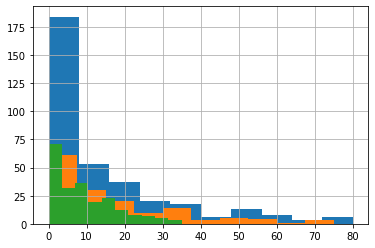

In [34]:
df2, supply_f, supply_simulation = init_supply_data(df)

price_ma, price_range, price_f, price_simulation = init_price_data(price_df)

supply_simulation, price_simulation, df_t, records_lst = run_simulation(
    df2, supply_f, supply_simulation, price_ma, price_range, price_f, price_simulation, silent=False)


<AxesSubplot:>

<AxesSubplot:>

(0.0, 250.0)

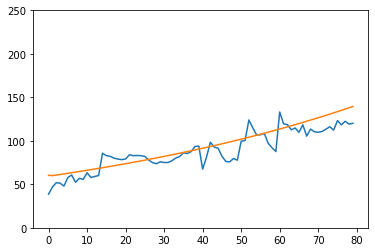

In [35]:
pd.Series(supply_simulation).plot()
pd.Series(preset_demand[:len(supply_simulation)]).plot()
plt.ylim((0, 1000/TIME_STEP_PER_YEAR))


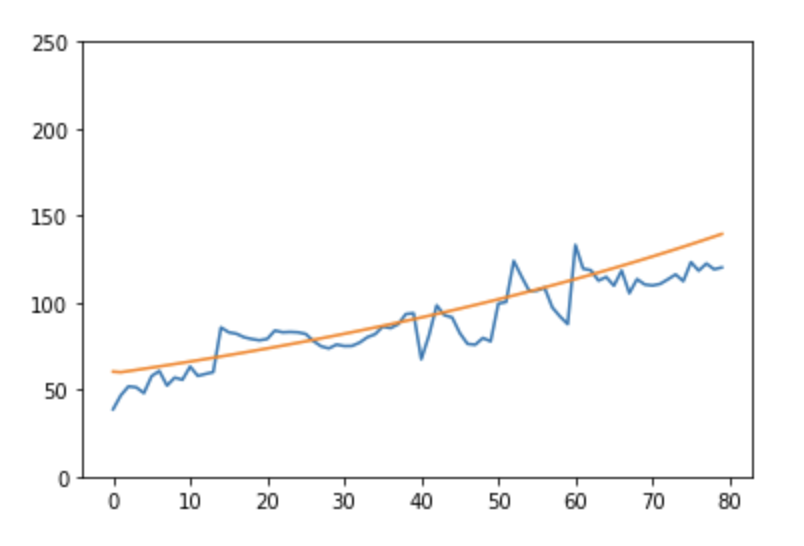

<AxesSubplot:>

(0.0, 250.0)

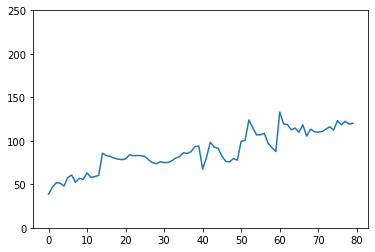

In [36]:
# supply

pd.Series(supply_simulation).plot()
plt.ylim((0, 1000/TIME_STEP_PER_YEAR))


<AxesSubplot:>

(0.0, 60000.0)

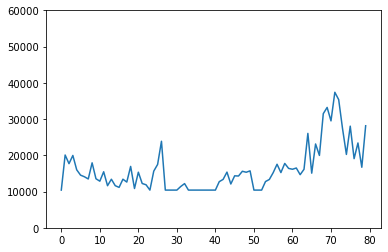

In [54]:
# price

# pd.Series(hist_price + price_simulation).plot()
pd.Series(price_simulation).plot()
plt.ylim((0, 60000))


<AxesSubplot:>

(0.0, 300.0)

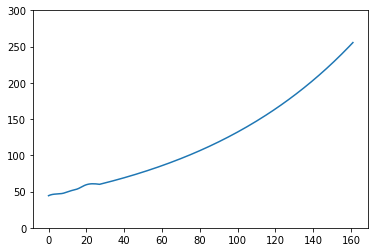

In [38]:
# demand

pd.Series(np.append(hist_demand_interpolated, np.array(preset_demand))).plot()
plt.ylim((0, 300))


## batch

  0%|          | 0/100 [00:00<?, ?it/s]

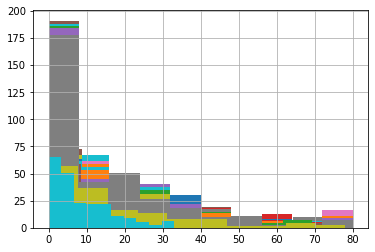

In [112]:
SIMULATION_STEP = 100

for i in tqdm(range(SIMULATION_STEP)):
    df2, supply_f, supply_simulation = init_supply_data(df)
    price_ma, price_range, price_f, price_simulation = init_price_data(price_df)
    supply_simulation, price_simulation, df_t, records_lst = run_simulation(
        df2, supply_f, supply_simulation, price_ma, price_range, price_f, price_simulation, silent=True)
    supply_simulation_resList += [supply_simulation]
    price_simulation_resList += [price_simulation]


In [113]:
supply_yearly = [[np.sum(lst[i*TIME_STEP_PER_YEAR:(i+1)*TIME_STEP_PER_YEAR]) for i in range(NUM_YEAR)]
                                                                 for lst in supply_simulation_resList]
supply_yearly = np.array(supply_yearly)
supply_yearly_mean = np.mean(supply_yearly, axis=0)


In [114]:
demand_yearly_mean = [preset_demand_ori[int(i*TIME_STEP_PER_YEAR+1)] for i in range(NUM_YEAR)]
demand_yearly = [demand_yearly_mean for i in range(SIMULATION_STEP)]
demand_yearly_mean = np.array(demand_yearly_mean)
demand_yearly = np.array(demand_yearly)


<AxesSubplot:>

<AxesSubplot:>

(0.0, 800.0)

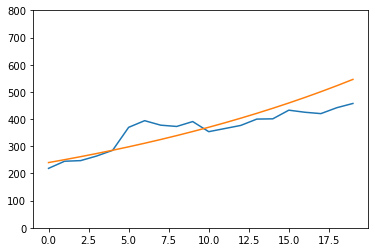

In [115]:
pd.Series(supply_yearly_mean).plot()
pd.Series(demand_yearly_mean).plot()
plt.ylim((0, 800))


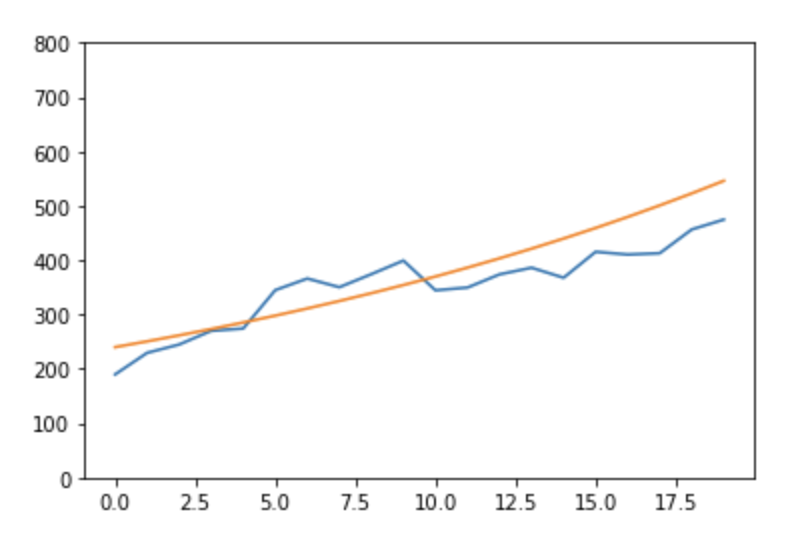

<AxesSubplot:>

(0.0, 800.0)

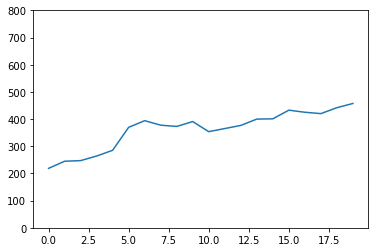

In [116]:
# supply

pd.Series(supply_yearly_mean).plot()
plt.ylim((0, 800))


<AxesSubplot:>

(0.0, 800.0)

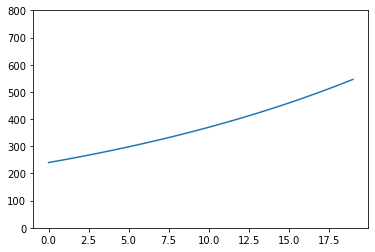

In [117]:
# demand

pd.Series(demand_yearly_mean).plot()
plt.ylim((0, 800))


In [118]:
price_yearly = [[np.mean(lst[i*TIME_STEP_PER_YEAR:(i+1)*TIME_STEP_PER_YEAR]) for i in range(NUM_YEAR)]
                                                                 for lst in price_simulation_resList]
price_yearly = np.array(price_yearly)
price_yearly_mean = np.mean(price_yearly, axis=0)


<AxesSubplot:>

(0.0, 30000.0)

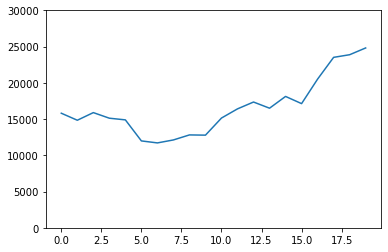

In [119]:
# supply

pd.Series(price_yearly_mean).plot()
plt.ylim((0, 30000))


## tuning

In [101]:
def batch_multi_simulation():
    supply_simulation_resList = []
    price_simulation_resList = []
    for i in tqdm(range(SIMULATION_STEP)):
#         print('simulation step', i+1)
        df2, supply_f, supply_simulation = init_supply_data(df)
        price_ma, price_range, price_f, price_simulation = init_price_data(price_df)
        supply_simulation, price_simulation, df_t, records_lst = run_simulation(
                df2, supply_f, supply_simulation, price_ma, price_range, price_f, price_simulation, silent=True)
        supply_simulation_resList += [supply_simulation]
        price_simulation_resList += [price_simulation]
    return supply_simulation_resList, price_simulation_resList


In [102]:
def evaluate(demand_yearly, supply_yearly):
    metric_res = np.sqrt(np.mean(np.square(demand_yearly - supply_yearly), axis=1))
    return metric_res


In [103]:
SIMULATION_STEP = 5

prob_produce_space = [0.1, 0.2, 0.3, 0.4]
base_response_space = [3, 5, 10, 20]
half_life_price_infl_space = [1, 2, 5, 10]
half_life_price_ma_space = [1, 2, 5]
# 4*4*4*3=192


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 1: (0.1, 3, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.96
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 2: (0.1, 3, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.82
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 3: (0.1, 3, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.85
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 4: (0.1, 3, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 5: (0.1, 3, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.75
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 6: (0.1, 3, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.74
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 7: (0.1, 3, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.79
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 8: (0.1, 3, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.69
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 9: (0.1, 3, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.63
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 10: (0.1, 3, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.76
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 11: (0.1, 3, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.68
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 12: (0.1, 3, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.62
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 13: (0.1, 5, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 14: (0.1, 5, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.97
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 15: (0.1, 5, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 16: (0.1, 5, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 17: (0.1, 5, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 18: (0.1, 5, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 19: (0.1, 5, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.82
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 20: (0.1, 5, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 21: (0.1, 5, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.77
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 22: (0.1, 5, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 23: (0.1, 5, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.78
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 24: (0.1, 5, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 25: (0.1, 10, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.02
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 26: (0.1, 10, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.04
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 27: (0.1, 10, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 28: (0.1, 10, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 29: (0.1, 10, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 30: (0.1, 10, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 31: (0.1, 10, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 32: (0.1, 10, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.97
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 33: (0.1, 10, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.95
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 34: (0.1, 10, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 35: (0.1, 10, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 36: (0.1, 10, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.93
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 37: (0.1, 20, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 38: (0.1, 20, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.17
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 39: (0.1, 20, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 40: (0.1, 20, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.12
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 41: (0.1, 20, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 42: (0.1, 20, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.09
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 43: (0.1, 20, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 44: (0.1, 20, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 45: (0.1, 20, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 46: (0.1, 20, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 47: (0.1, 20, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.09
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 48: (0.1, 20, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.07
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 49: (0.2, 3, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.89
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 50: (0.2, 3, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 51: (0.2, 3, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 52: (0.2, 3, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.78
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 53: (0.2, 3, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.76
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 54: (0.2, 3, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.79
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 55: (0.2, 3, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.75
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 56: (0.2, 3, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.66
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 57: (0.2, 3, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.66
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 58: (0.2, 3, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.78
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 59: (0.2, 3, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.69
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 60: (0.2, 3, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.67
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 61: (0.2, 5, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.93
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 62: (0.2, 5, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.89
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 63: (0.2, 5, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 64: (0.2, 5, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.89
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 65: (0.2, 5, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 66: (0.2, 5, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.81
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 67: (0.2, 5, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.89
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 68: (0.2, 5, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.8
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 69: (0.2, 5, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.77
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 70: (0.2, 5, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.85
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 71: (0.2, 5, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.79
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 72: (0.2, 5, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.75
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 73: (0.2, 10, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.06
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 74: (0.2, 10, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.06
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 75: (0.2, 10, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 76: (0.2, 10, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 77: (0.2, 10, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.02
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 78: (0.2, 10, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 79: (0.2, 10, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.96
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 80: (0.2, 10, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 81: (0.2, 10, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.92
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 82: (0.2, 10, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 83: (0.2, 10, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 84: (0.2, 10, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 95.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 85: (0.2, 20, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.25
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 86: (0.2, 20, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.33
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 87: (0.2, 20, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.28
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 88: (0.2, 20, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.16
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 89: (0.2, 20, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.23
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 90: (0.2, 20, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.25
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 91: (0.2, 20, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.11
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 92: (0.2, 20, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.54
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 93: (0.2, 20, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.22
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 94: (0.2, 20, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.36
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 95: (0.2, 20, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.17
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 96: (0.2, 20, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.18
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 97: (0.3, 3, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 98: (0.3, 3, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.97
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 99: (0.3, 3, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.19
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 100: (0.3, 3, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.06
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 101: (0.3, 3, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.81
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 102: (0.3, 3, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 103: (0.3, 3, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.92
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 104: (0.3, 3, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 105: (0.3, 3, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.8
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 106: (0.3, 3, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 107: (0.3, 3, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 108: (0.3, 3, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.72
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 109: (0.3, 5, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 110: (0.3, 5, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 111: (0.3, 5, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 112: (0.3, 5, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 9.02
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 113: (0.3, 5, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 8.75
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 114: (0.3, 5, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 9.71
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 115: (0.3, 5, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 13.73
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 116: (0.3, 5, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 13.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 117: (0.3, 5, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 12.32
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 118: (0.3, 5, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.22
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 119: (0.3, 5, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.04
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 120: (0.3, 5, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 121: (0.3, 10, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.71
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 122: (0.3, 10, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.75
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 123: (0.3, 10, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 124: (0.3, 10, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.3
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 125: (0.3, 10, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.29
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 126: (0.3, 10, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.42
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 127: (0.3, 10, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 121.67
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 128: (0.3, 10, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.99
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 129: (0.3, 10, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 130: (0.3, 10, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 131: (0.3, 10, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 132: (0.3, 10, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.88
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 133: (0.3, 20, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.17
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 134: (0.3, 20, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 135: (0.3, 20, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.12
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 136: (0.3, 20, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.12
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 137: (0.3, 20, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.16
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 138: (0.3, 20, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 139: (0.3, 20, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.09
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 140: (0.3, 20, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 141: (0.3, 20, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 142: (0.3, 20, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 143: (0.3, 20, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.47
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 144: (0.3, 20, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 12.05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 145: (0.4, 3, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.37
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 146: (0.4, 3, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.04
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 147: (0.4, 3, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.92
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 148: (0.4, 3, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.03
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 149: (0.4, 3, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.91
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 150: (0.4, 3, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.96
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 151: (0.4, 3, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.23
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 152: (0.4, 3, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.98
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 153: (0.4, 3, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.13
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 154: (0.4, 3, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.27
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 155: (0.4, 3, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 11.03
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 156: (0.4, 3, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.95
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 157: (0.4, 5, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 10.25
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 158: (0.4, 5, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.02
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 159: (0.4, 5, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 160: (0.4, 5, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.93
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 161: (0.4, 5, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.83
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 162: (0.4, 5, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.85
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 163: (0.4, 5, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 164: (0.4, 5, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.84
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 165: (0.4, 5, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.79
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 166: (0.4, 5, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 167: (0.4, 5, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.82
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 168: (0.4, 5, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.81
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 169: (0.4, 10, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.03
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 170: (0.4, 10, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.07
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 171: (0.4, 10, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.09
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 172: (0.4, 10, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.03
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 173: (0.4, 10, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.95
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 174: (0.4, 10, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.94
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 175: (0.4, 10, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.96
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 176: (0.4, 10, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.92
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 177: (0.4, 10, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.92
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 178: (0.4, 10, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.96
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 179: (0.4, 10, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.97
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 180: (0.4, 10, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 6.88
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 181: (0.4, 20, 1, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 182: (0.4, 20, 1, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.19
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 183: (0.4, 20, 1, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 184: (0.4, 20, 2, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.14
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 185: (0.4, 20, 2, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.13
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 186: (0.4, 20, 2, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.13
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 187: (0.4, 20, 5, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.12
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 188: (0.4, 20, 5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.12
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 189: (0.4, 20, 5, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.09
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 190: (0.4, 20, 10, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 191: (0.4, 20, 10, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.07
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
combination 192: (0.4, 20, 10, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

time consumed: 7.08


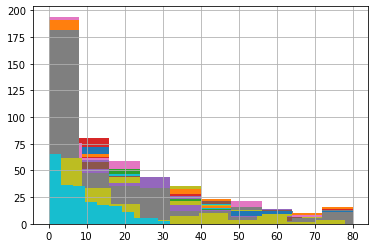

In [104]:
lsts = [prob_produce_space, base_response_space, half_life_price_infl_space, half_life_price_ma_space]
score_lst = []
score_dic = {}

var_comb_cnt = 0 
for i in itertools.product(*lsts):
#     init vars
    start = time.time()
    var_comb_cnt += 1
    print('+++'*50, '\ncombination %d: %s'%(var_comb_cnt, i))

    prob_produce = i[0] # probability of developing deposits reaching operating stage 
    base_response = i[1] # smaller the smalaler ds effect
    half_life_price_infl = i[2] # larger the smaller ds effect
    half_life_price_ma = i[3]

    half_life_price_ma *= TIME_STEP_PER_YEAR
    half_life_price_infl *= TIME_STEP_PER_YEAR
    a_ppf = 1 - np.exp(np.log(0.5) / (half_life_price_ma))
    r_pfr = -np.log(2) / half_life_price_infl
    
    supply_simulation_resList, price_simulation_resList = batch_multi_simulation()
    supply_yearly = [[np.sum(lst[i*TIME_STEP_PER_YEAR:(i+1)*TIME_STEP_PER_YEAR]) for i in range(NUM_YEAR)]
                                                                 for lst in supply_simulation_resList]
    supply_yearly = np.array(supply_yearly)
    demand_yearly_mean = [preset_demand_ori[int(i*TIME_STEP_PER_YEAR+1)] for i in range(NUM_YEAR)]
    demand_yearly = [demand_yearly_mean for i in range(SIMULATION_STEP)]
    demand_yearly = np.array(demand_yearly)

    diff = evaluate(demand_yearly, supply_yearly)
    score = np.mean(diff)    
    score_dic.update({i:score})
    
    end = time.time()
    print('time consumed:', np.round((end-start)/60, 2))


In [107]:
dict(sorted(score_dic.items(), key=lambda item: item[1]))

{(0.2, 10, 2, 1): 51.457537854266306,
 (0.1, 10, 1, 2): 53.7501280144307,
 (0.3, 10, 1, 5): 55.346806274664026,
 (0.2, 20, 10, 5): 56.67662404214777,
 (0.2, 10, 1, 2): 57.12918840486759,
 (0.1, 10, 1, 1): 58.58011687277839,
 (0.4, 10, 1, 5): 58.66756666312862,
 (0.3, 10, 5, 1): 58.84304877351133,
 (0.1, 10, 5, 2): 59.44784166381079,
 (0.3, 10, 1, 1): 59.63589376352293,
 (0.4, 20, 10, 5): 60.55324466419445,
 (0.3, 10, 1, 2): 60.60055650518753,
 (0.1, 10, 2, 1): 60.7358471486119,
 (0.3, 20, 2, 5): 60.85946535141757,
 (0.2, 10, 1, 1): 61.33271773387612,
 (0.4, 10, 2, 5): 61.42998795136018,
 (0.1, 20, 10, 1): 61.757635647096286,
 (0.4, 10, 2, 2): 62.66995539377204,
 (0.2, 20, 10, 1): 62.77727776212093,
 (0.1, 20, 10, 5): 62.92806117045004,
 (0.1, 20, 5, 2): 63.48406642063262,
 (0.1, 10, 1, 5): 63.61637624243777,
 (0.1, 20, 10, 2): 63.82252949061093,
 (0.3, 20, 2, 1): 63.97951499522462,
 (0.3, 10, 2, 5): 64.35248572917354,
 (0.1, 10, 2, 5): 64.47033483356203,
 (0.4, 20, 2, 1): 64.6334118953

# Visualization

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
labels = df['country_name'].value_counts().index.tolist()[:19]


In [ ]:
data = tp[11].copy()
data = data[data['production (mt)']>0]
data = data.sort_values(by='production (mt)', ascending=False).head(70)
data['production (mt)_bin'] = pd.cut(data['production (mt)'], bins=[-np.inf, 1000, 2000, 5000, 10000, 20000, 50000, 100000, np.inf], labels=range(1, 9)).astype(float)
data = data.rename(columns={'production (mt)_bin':'productivity level'})

data.loc[:, 'country_name_new'] = data.loc[:, 'country_name']
data.loc[~df['country_name'].isin(labels), 'country_name_new'] = 'others'

data = data.sort_values(by='country_name_new', ascending=False)

token = 'pk.eyJ1IjoiemlwcGVlIiwiYSI6ImNreGluZW5iMzAwNTUyb256aGxiYzJhNm8ifQ.MbI3pSI-pcwr2QA070dtew'
fig = px.scatter_mapbox(data,
                        lon = 'longitude',
                        lat = 'latitude',
#                         color = 'country_name_new',
                        title = 'nickel mine distribution',
                        zoom = 1,
                        category_orders=dict(zip(labels+['others'], range(20))),
                        size = 'production (mt)',
                        size_max = data['production (mt)'].max()/5000,
                        width=1000,
                        height=600,
                        color_continuous_scale = px.colors.carto.Sunsetdark)
fig.update_layout(mapbox = {'accesstoken':token, 'style':"light" },
                 title = dict(x=0.5,xref='paper'),
                 margin={'l':10,"r":0,'t':50,'b':10})


In [331]:
2968289 + 10113337 + 4279599 + 28534442 + 951732 + 11191 + 11040 + 527704 + 3128723 + 524345 + 44897522 + 734927 + 25631 + 11 + 28835 + 1774 + 5219 + 3121 + 5737 + 934 + 3 + 130 + 8931 + 24 + 24473 + 15644 + 7 + 26 + 26 + 605 + 7740438 + 666635 + 5424267 + 679442 + 23564337 + 11676880 + 112224 + 15440 + 141883 + 202456 + 25062 + 4782 + 19353 + 624 + 123236 + 26 + 1 + 25317065 + 46587817 + 188

219106138